In [1]:
import json

In [ ]:
def get_scores_prompting(task, dataset, n_shot, base_path="../../zero-shot-absa-quad/generations/zeroshot/", data_type="test"):
    power, vram, times = [], [], []
    n_samples = 0

    for seed in range(5):
        file_path = f"{base_path}/{task}_{dataset}_{data_type}_gemma3:27b_{seed}{'_label' if data_type == 'test' else ''}_{n_shot}_PERFORMANCE.json"
        with open(file_path, "r") as f:
            data = json.load(f)
            n_samples += len(data)
            power.extend(ex["avg_gpu_power_eval_W"] for ex in data)
            vram.extend(ex["avg_gpu_vram_eval_MB"] for ex in data)
            times.extend(ex["total_time_eval"] for ex in data)

    return {
        "avg_gpu_power_eval_W": sum(power) / len(power),
        "avg_gpu_vram_eval_MB": sum(vram) / len(vram),
        "total_time_eval": sum(times) * 20 / 60, # 60 seconds to minutes
        "n_samples": n_samples * 20 / 5,
        "kWH": ((((sum(power) / len(power)) * sum(times)) * 20)) / (36 * 100000)
    }

def get_scores_prompting_all(task, n_shot, base_path="../../zero-shot-absa-quad/generations/zeroshot/", data_type="test"):
    datasets = ["rest15", "rest16", "hotels", "coursera", "flightabsa"]
    all_stats = [get_scores_prompting(task, ds, n_shot, base_path, data_type) for ds in datasets]

    return {
        key: sum(stat[key] for stat in all_stats) / len(all_stats)
        for key in all_stats[0]
    }


In [18]:
get_scores_prompting("asqp", "rest16", 10)

{'avg_gpu_power_eval_W': 210.71087273666666,
 'avg_gpu_vram_eval_MB': 19053.791476758903,
 'total_time_eval': 100.46119944254558,
 'n_samples': 540.0,
 'kWH': 0.3528044501785184}

In [15]:
get_scores_prompting_all("asqp", 50), get_scores_prompting_all("asqp", 50, "../_out_synthetic_examples/01_llm_annotate_train", "train")

({'avg_gpu_power_eval_W': 220.67568475592188,
  'avg_gpu_vram_eval_MB': 19201.974380054056,
  'total_time_eval': 346.0068794886271,
  'n_samples': 448.0,
  'kWH': 1.273089082146471},
 {'avg_gpu_power_eval_W': 222.9056455265581,
  'avg_gpu_vram_eval_MB': 19319.206751650316,
  'total_time_eval': 703.6838806788126,
  'n_samples': 1192.0,
  'kWH': 2.6167181015005334})

In [4]:
def get_scores_la(
    task,
    dataset,
    n_shot,
    method,
    base_path="../_out_fine_tunings/01_llm_annotate_train",
):
    (
        avg_gpu_vram_train_MB,
        avg_gpu_power_train_W,
        total_time_eval,
        total_time_train,
        avg_gpu_vram_eval_MB,
        avg_gpu_power_eval_W,
    ) = ([], [], [], [], [], [])
    n_samples = 0

    for seed in range(5):
        file_path = f"{base_path}/{method}_full_{task}_{n_shot}_{dataset}_{seed}_PERFORMANCE.json"
        
        with open(file_path, "r") as f:
            data = json.load(f)
            n_samples += len(data["all_preds"])
            avg_gpu_vram_train_MB.append(data["avg_gpu_vram_train_MB"])
            avg_gpu_power_train_W.append(data["avg_gpu_power_train_W"])
            total_time_eval.append(data["total_time_eval"])
            total_time_train.append(data["total_time_train"])
            avg_gpu_vram_eval_MB.append(data["avg_gpu_vram_eval_MB"])
            avg_gpu_power_eval_W.append(data["avg_gpu_power_eval_W"])
            
    n_dev = 10 if method == "llm_Meta-Llama-3.1-8B-Instruct-bnb-4bit" else 20
    
    return {
        "avg_gpu_vram_train_MB": sum(avg_gpu_vram_train_MB) / 5,
        "avg_gpu_power_train_W": sum(avg_gpu_power_train_W) / 5,
        "total_time_eval": sum(total_time_eval) / 5 / 60 ,
        "total_time_train": sum(total_time_train) / 5 * n_dev / 60,
        "avg_gpu_vram_eval_MB": sum(avg_gpu_vram_eval_MB) / 5,
        "avg_gpu_power_eval_W": sum(avg_gpu_power_eval_W) / 5,
        "n_samples_test": n_samples / 5,
        "kWH_train": (sum(avg_gpu_power_train_W) / 5 * sum(total_time_train) / 5 * n_dev ) / (36 * 100000),
        "kWH_eval": (sum(avg_gpu_power_eval_W) / 5 * sum(total_time_eval) / 5 ) / (36 * 100000),
    }
    
def get_scores_la_all(
    task,
    n_shot,
    method,
    base_path="../_out_fine_tunings/01_llm_annotate_train",
):
    datasets = ["rest15", "rest16", "hotels", "coursera", "flightabsa"]
    all_stats = [get_scores_la(task, ds, n_shot, method, base_path) for ds in datasets]

    return {
        key: sum(stat[key] for stat in all_stats) / len(all_stats)
        for key in all_stats[0]
    }

In [5]:
get_scores_la_all("asqp", 0, "dlo")

{'avg_gpu_vram_train_MB': 14314.948497117342,
 'avg_gpu_power_train_W': 152.1884994459477,
 'total_time_eval': 3.274790122350057,
 'total_time_train': 67.5902837530772,
 'avg_gpu_vram_eval_MB': 15108.620183531555,
 'avg_gpu_power_eval_W': 107.63152346988386,
 'n_samples_test': 453.6,
 'kWH_train': 0.1695060041436463,
 'kWH_eval': 0.005869187272358828}

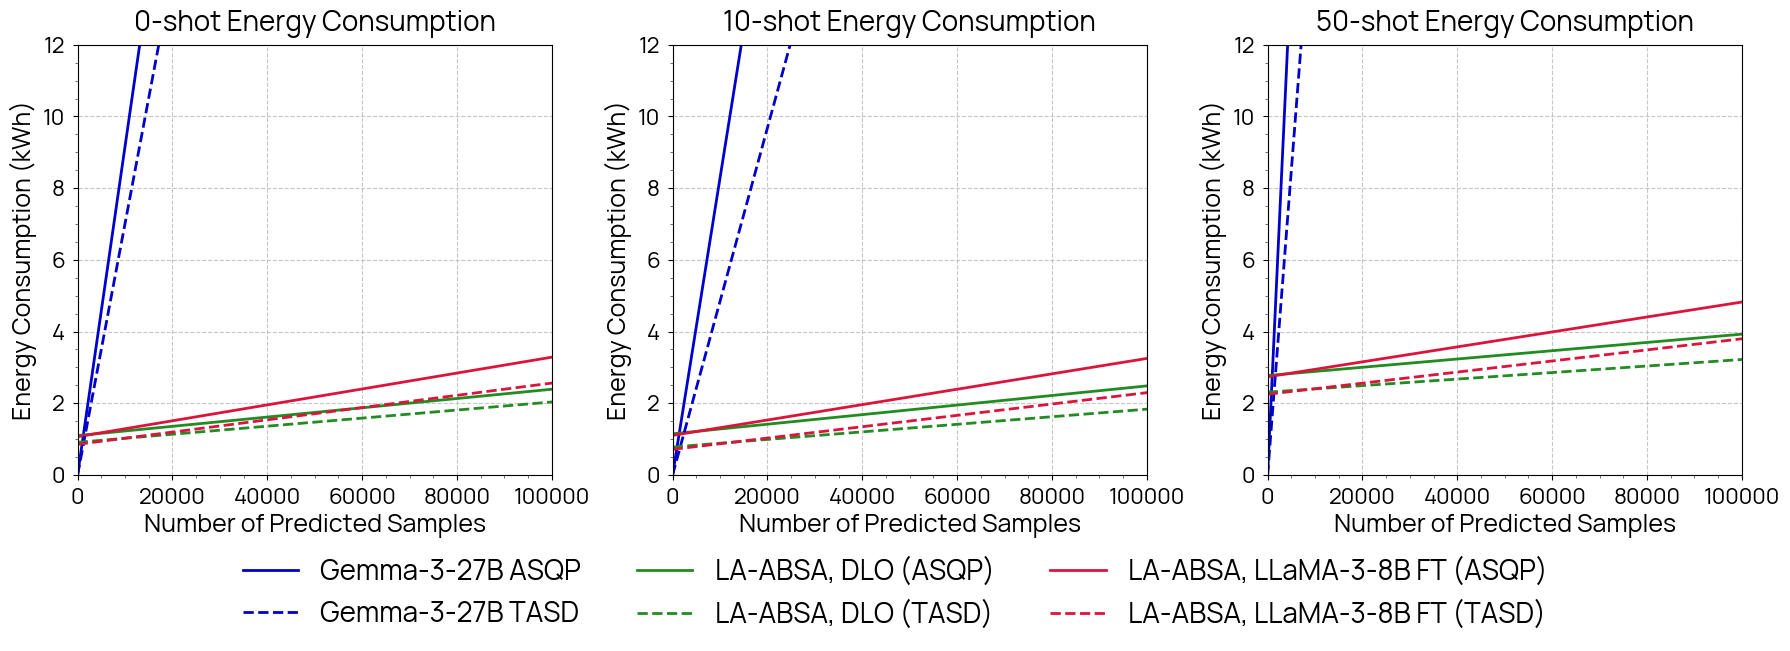

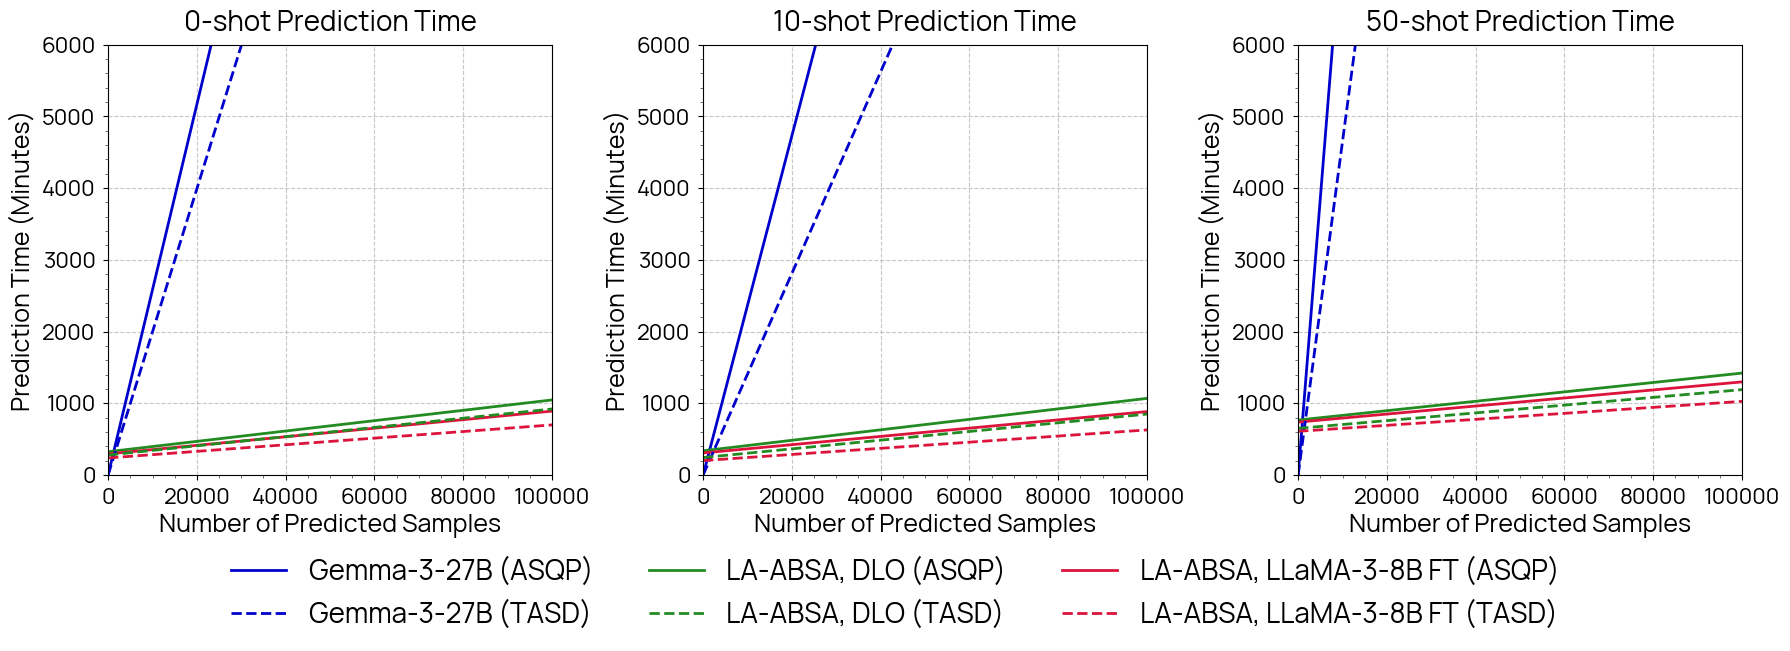

In [13]:
import matplotlib.pyplot as plt
from matplotlib import font_manager
import numpy as np

# Globale Variablen für das 1x3 Layout
fig = None
axes = None
subplot_counter = 0
all_handles = []
all_labels = []
current_plot_type = None

def setup_1x3_plot(plot_type):
    """Initialisiert das 1x3 Plot Layout"""
    global fig, axes, subplot_counter, current_plot_type
    
    font_path = '_fonts/Manrope-Regular.ttf'
    font_manager.fontManager.addfont(font_path)
    prop = font_manager.FontProperties(fname=font_path)

    plt.rcParams['font.family'] = 'sans-serif'
    plt.rcParams['font.sans-serif'] = prop.get_name()
    plt.style.use('seaborn-v0_8-paper') 

    fig, axes = plt.subplots(1, 3, figsize=(18, 6), dpi=100)
    subplot_counter = 0
    current_plot_type = plot_type
    
    return fig, axes

def draw_plot(title_x, title_y, plot_title, data=[], maximum_y=1000, maximum_x=1000):
    global fig, axes, subplot_counter, all_handles, all_labels
    
    # Bestimme die Position im 1x3 Grid
    ax = axes[subplot_counter]
    
    # Plot die Daten (ohne Punkte)
    for d in data:
        x = np.array(d["x"])
        y = np.array(d["y"])
        
        # Keine Punkte mehr, nur Linien
        if x[1] > x[0]:
            N_TIMES_SCALE = 1000   
            x[1] = x[1] * N_TIMES_SCALE
            y[1] = y[1] + (y[1] - y[0]) * (N_TIMES_SCALE-1)
        
        # Bestimme Linienstil basierend auf Task
        linestyle = '--' if d.get("task") == "tasd" else '-'
         
        line = ax.plot(x, y, color=d["line_color"], linewidth=2, 
                      linestyle=linestyle, label=d["legend_title_line"])
        
        # Sammle Handles und Labels für die gemeinsame Legende
        if d["legend_title_line"] not in all_labels:
            all_handles.append(line[0])
            all_labels.append(d["legend_title_line"])

    ax.set_xlabel(title_x, fontsize=18)
    ax.set_ylabel(title_y, fontsize=18)
    ax.set_title(plot_title, fontsize=20, pad=10)

    ax.grid(True, linestyle='--', alpha=0.7)
    ax.minorticks_on()

    ax.set_xlim(0, maximum_x)
    ax.set_ylim(0, maximum_y)
    
    ax.tick_params(axis='both', which='major', labelsize=16)
    
    subplot_counter += 1
    
    # Wenn alle 3 Plots erstellt wurden, füge die gemeinsame Legende hinzu und speichere
    if subplot_counter == 3:
        finalize_plot()

def finalize_plot():
    """Fügt die gemeinsame Legende hinzu und speichert das Plot"""
    global fig, all_handles, all_labels, current_plot_type
    
    sorted_handles_labels = sorted(zip(all_labels, all_handles), key=lambda x: x[0])
    all_labels, all_handles = zip(*sorted_handles_labels)
    
    # Gemeinsame Legende unterhalb der Plots
    fig.legend(
        all_handles, 
        all_labels,
        loc='lower center',
        bbox_to_anchor=(0.5, -0.1),
        ncol=3,  # 3 Spalten für bessere Platznutzung
        fontsize=20,
        frameon=False
    )
    
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.2)  # Platz für die Legende
    
    # Speichere mit entsprechendem Namen
    filename = f"_out_table/prediction_{current_plot_type}_plots_1x3.pdf"
    plt.savefig(filename, format="pdf", dpi=300, bbox_inches="tight")
    plt.show()
    
    # Reset für nächste Verwendung
    reset_plot_state()

def reset_plot_state():
    """Setzt den Plot-Status zurück"""
    global fig, axes, subplot_counter, all_handles, all_labels, current_plot_type
    fig = None
    axes = None
    subplot_counter = 0
    all_handles = []
    all_labels = []
    current_plot_type = None

# Angepasste Farbpalette für bessere Unterscheidung
line_colors = {
    "dlo": "#228B22",       # Waldgrün
    "llm_Meta-Llama-3.1-8B-Instruct-bnb-4bit": "#DC143C",  # Karmesinrot
    "gemma3:27b": "#0000CD",  # Mittelblau
}

model_key_to_name = {
    "llm_Meta-Llama-3.1-8B-Instruct-bnb-4bit": "LLaMA-3-8B FT",
    "dlo": "DLO"
}

def get_scores_for_task(task, shot_count, method=None, data_type=None):
    """Hilfsfunktion für einzelne Tasks"""
    if method is None:
        # Standard prompting
        return get_scores_prompting_all(task, shot_count)
    elif method == "annotate":
        # LLM annotate train
        return get_scores_prompting_all(
            task,
            shot_count,
            base_path="../_out_synthetic_examples/01_llm_annotate_train",
            data_type="train",
        )
    else:
        # LA with specified method (paraphrase or dlo)
        return get_scores_la_all(task, shot_count, method)

def create_all_plots():
    """Erstellt alle Plots - zwei PDFs mit jeweils drei Plots (separate ASQP und TASD Lines)"""
    
    # Erstelle Plots für Energy Consumption
    setup_1x3_plot("energy")
    
    for shot_count in [0, 10, 50]:
        # Get scores for both tasks separately
        plot_data = []
        
        for task in ["asqp", "tasd"]:
            # Standard prompting (Gemma-3-27B gibt es immer)
            gemma_scores = get_scores_for_task(task, shot_count)
            task_label = "ASQP" if task == "asqp" else "TASD"
            
            plot_data.append({
                "x": [0, gemma_scores["n_samples"]],
                "y": [0, gemma_scores["kWH"]],
                "legend_title_line": f"Gemma-3-27B {task_label}",
                "line_color": line_colors[f"gemma3:27b"],
                "task": task
            })
            
            # LA Methoden (DLO und LLaMA gibt es bei allen Shot-Counts)
            for method in ["dlo", "llm_Meta-Llama-3.1-8B-Instruct-bnb-4bit"]:
                annotate_scores = get_scores_for_task(task, shot_count, "annotate")
                method_scores = get_scores_for_task(task, shot_count, method)
                
                plot_data.append({
                    "x": [0, method_scores["n_samples_test"]],
                    "y": [
                        annotate_scores["kWH"] + method_scores["kWH_train"],
                        annotate_scores["kWH"] + method_scores["kWH_train"] + method_scores["kWH_eval"],
                    ],
                    "legend_title_line": f"LA-ABSA, {model_key_to_name[method]} ({task_label})",
                    "line_color": line_colors[f"{method}"],
                    "task": task
                })
        
        draw_plot(
            "Number of Predicted Samples",
            "Energy Consumption (kWh)",
            f"{shot_count}-shot Energy Consumption",
            plot_data,
            maximum_y=12,  # Angepasst für separate Tasks
            maximum_x=100000,
        )

    # Erstelle Plots für Prediction Time
    setup_1x3_plot("time")
    
    for shot_count in [0, 10, 50]:
        # Get scores for both tasks separately
        plot_data = []
        
        for task in ["asqp", "tasd"]:
            # Standard prompting (Gemma-3-27B gibt es immer)
            gemma_scores = get_scores_for_task(task, shot_count)
            task_label = "ASQP" if task == "asqp" else "TASD"
            
            plot_data.append({
                "x": [0, gemma_scores["n_samples"]],
                "y": [0, gemma_scores["total_time_eval"]],
                "legend_title_line": f"Gemma-3-27B ({task_label})",
                "line_color": line_colors[f"gemma3:27b"],
                "task": task
            })
            
            # LA Methoden (DLO und LLaMA gibt es bei allen Shot-Counts)
            for method in ["dlo", "llm_Meta-Llama-3.1-8B-Instruct-bnb-4bit"]:
                annotate_scores = get_scores_for_task(task, shot_count, "annotate")
                method_scores = get_scores_for_task(task, shot_count, method)
                
                plot_data.append({
                    "x": [0, method_scores["n_samples_test"]],
                    "y": [
                        annotate_scores["total_time_eval"] + method_scores["total_time_train"],
                        annotate_scores["total_time_eval"] + method_scores["total_time_train"] + method_scores["total_time_eval"],
                    ],
                    "legend_title_line": f"LA-ABSA, {model_key_to_name[method]} ({task_label})",
                    "line_color": line_colors[f"{method}"],
                    "task": task
                })
        
        draw_plot(
            "Number of Predicted Samples",
            "Prediction Time (Minutes)",
            f"{shot_count}-shot Prediction Time",
            plot_data,
            maximum_y=6000,  # Angepasst für separate Tasks
            maximum_x=100000,
        )

# Zum Ausführen rufen Sie einfach auf:
create_all_plots()